In [1]:
%matplotlib inline
import os
import time
import numpy
import pandas as pd
import matplotlib

In [27]:
# Example of coupled execution
# log_files = {'new': 'slurm-4240.out'}

# Example of completed uncoupled, with bad node?
log_files = {'new': 'slurm-4457.out'}

# Example of completed uncoupled, without bad node?
log_files = {'new': 'slurm-4459.out'}

log_files = {'new': 'slurm-4744.out'}

# log_files = {'new': 'slurm-4236.out'}
# log_files = {1: 'slurm-3600.out', 4: 'slurm-3601.out', 16: 'slurm-3602.out', 'rwlock': 'slurm-4235.out'}

In [28]:
 def log_file_to_dataframe(log_file):
    fp = open(log_file, 'r')
    perf_records = []
    for line in fp:
        if line.startswith('PE ') and line.find('- total') != -1:
            tokens = line.split()

            # Sample line in log file:
            #   PE 6 - total 1336.802000 ms - metadata 54.481000 ms (50.733000 0.000000) - \
            #     summary 3.805000 ms (1.763000 0.072000 1.970000 | 0.065000 0.037000 0.048000 1.820000) - \
            #     edges 1278.047000 ms (1190.644000 80.641000) - neighbor updates 0.411000 ms - \
            #     abort 0.058000 ms - 0 spins - 9 / 16 PE neighbors  - partition window = , 1522 / 28900 active - \
            #     aborting? 0 - last step? 0 - remote cache hits=6688 misses=3553 age misses=0, feature cache hits=0 misses=0
            #
            # Sample new line in log file:
            #   PE 11 - total 42.046000 ms - metadata 26.715000 ms (26.212000 0.000000) - \
            #     summary 4.765000 ms (0.133000 0.023000 4.609000 | 1.428000 1.406000 1.281000 0.481000) - \
            #     edges 10.411000 ms (2.730000 7.445000) - neighbor updates 0.111000 ms - coupling 0.020000 ms - \
            #     throttling 0.024000 ms - 0 spins - 6 / 256 PE neighbors  - partition window = , 43 / 10000 active - \
            #     aborting? 0 - last step? 0 - remote cache hits=1611 misses=375 age misses=0, feature cache hits=0 misses=0
            index = 1
            pe = int(tokens[index])
            index += 3
            
            timestep = int(tokens[index])
            index += 3
            
            total = float(tokens[index])
            index += 4
            
            metadata = float(tokens[index])
            index += 6
            
            summary = float(tokens[index])
            index += 2
            summary_actor_partitions = float(tokens[index][1:])
            index += 1
            summary_time_window = float(tokens[index])
            index += 1
            summary_update_neighbors = float(tokens[index])
            index += 2
            summary_update_neighbors_lock = float(tokens[index])
            index += 1
            summary_update_neighbors_getmem = float(tokens[index])
            index += 1
            summary_update_neighbors_unlock = float(tokens[index])
            index += 1
            summary_update_neighbors_body = float(tokens[index][:len(tokens[index]) - 1])
            index += 3
            
            edges = float(tokens[index])
            index += 2
            edges_updates = float(tokens[index][1:])
            index += 1
            edges_getmem = float(tokens[index][:-1])
            index += 4
            
            neighbor_updates = float(tokens[index])
            index  += 5
            
            coupled_values = float(tokens[index])
            index += 4
            
            coupling = float(tokens[index])
            index += 2
            
            n_coupled_spins_str = tokens[index]
            n_coupled_spins_str = n_coupled_spins_str[1:]
            n_coupled_spins_str = n_coupled_spins_str[:len(n_coupled_spins_str) - 1]
            n_coupled_spins = int(n_coupled_spins_str)
            index += 3
            
            throttling = float(tokens[index])
            index += 3
            
            spins = int(tokens[index])
            index += 3
            
            n_neighbors = int(tokens[index])
            index += 10
            
            active_partitions = int(tokens[index])
            index += 14
            
            cache_hits_str = tokens[index]
            cache_hits = int(cache_hits_str.split('=')[1])
            index += 1
            
            cache_misses_str = tokens[index]
            cache_misses = int(cache_misses_str.split('=')[1])
            index += 2
            
            cache_age_misses_str = tokens[index]
            cache_age_misses_str = cache_age_misses_str.split('=')[1]
            cache_age_misses_str = cache_age_misses_str[:-1]
            cache_age_misses = int(cache_age_misses_str)

            perf_records.append({'pe': pe,
                                 'timestep': timestep,
                                 'total': total,
                                 'metadata': metadata,
                                 'summary': summary,
                                 'summary_actor_partitions': summary_actor_partitions,
                                 'summary_time_window': summary_time_window,
                                 'summary_update_neighbors': summary_update_neighbors,
                                 'summary_update_neighbors_lock': summary_update_neighbors_lock,
                                 'summary_update_neighbors_getmem': summary_update_neighbors_getmem,
                                 'summary_update_neighbors_unlock': summary_update_neighbors_unlock,
                                 'summary_update_neighbors_body': summary_update_neighbors_body,
                                 'edges': edges,
                                 'edges_updates': edges_updates,
                                 'edges_getmem': edges_getmem,
                                 'neighbor_updates': neighbor_updates,
                                 'coupling': coupling,
                                 'n_coupled_spins': n_coupled_spins,
                                 'coupled_values': coupled_values,
                                 'throttling': throttling,
                                 'spins': spins,
                                 'n_neighbors': n_neighbors,
                                 'active_partitions': active_partitions,
                                 'cache_hits': cache_hits,
                                 'cache_misses': cache_misses,
                                 'cache_age_misses': cache_age_misses})
    fp.close()
    return pd.DataFrame(perf_records)

In [29]:
dfs = {}
for nnodes in log_files:
    dfs[nnodes] = log_file_to_dataframe(log_files[nnodes])

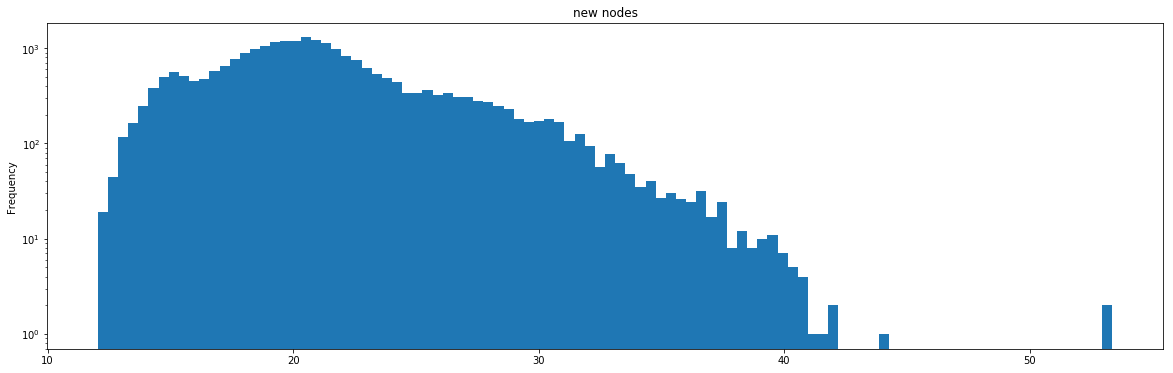

In [30]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['total'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes', logy = True)

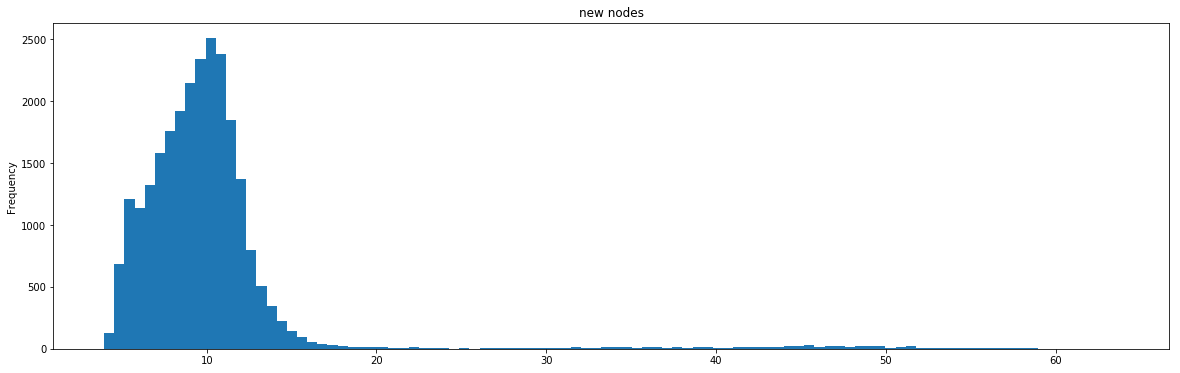

In [7]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['summary'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

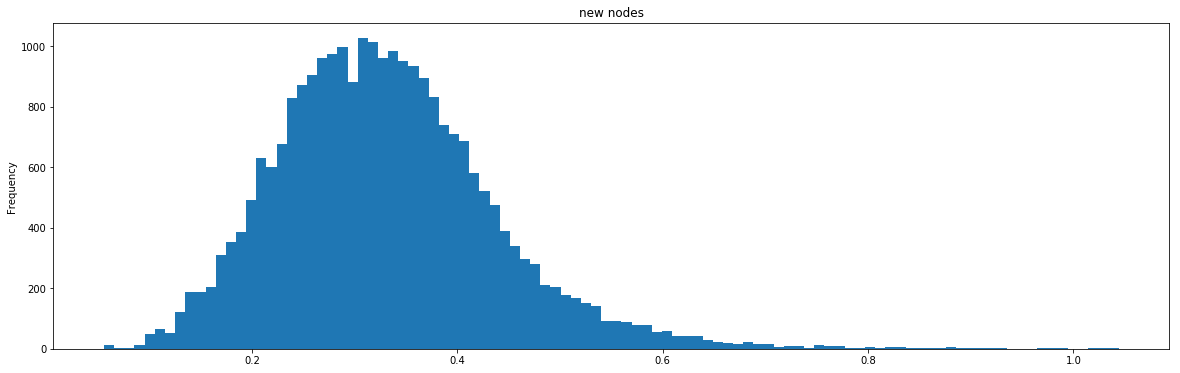

In [8]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['metadata'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

In [9]:
dfs['new'].columns

Index([u'active_partitions', u'cache_age_misses', u'cache_hits',
       u'cache_misses', u'coupled_values', u'coupling', u'edges',
       u'edges_getmem', u'edges_updates', u'metadata', u'n_coupled_spins',
       u'n_neighbors', u'neighbor_updates', u'pe', u'spins', u'summary',
       u'summary_actor_partitions', u'summary_time_window',
       u'summary_update_neighbors', u'summary_update_neighbors_body',
       u'summary_update_neighbors_getmem', u'summary_update_neighbors_lock',
       u'summary_update_neighbors_unlock', u'throttling', u'timestep',
       u'total'],
      dtype='object')

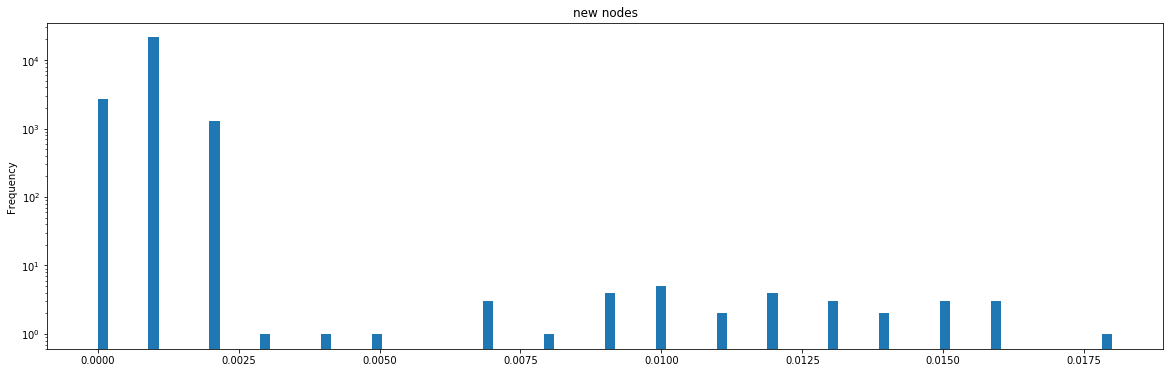

In [10]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['coupling'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

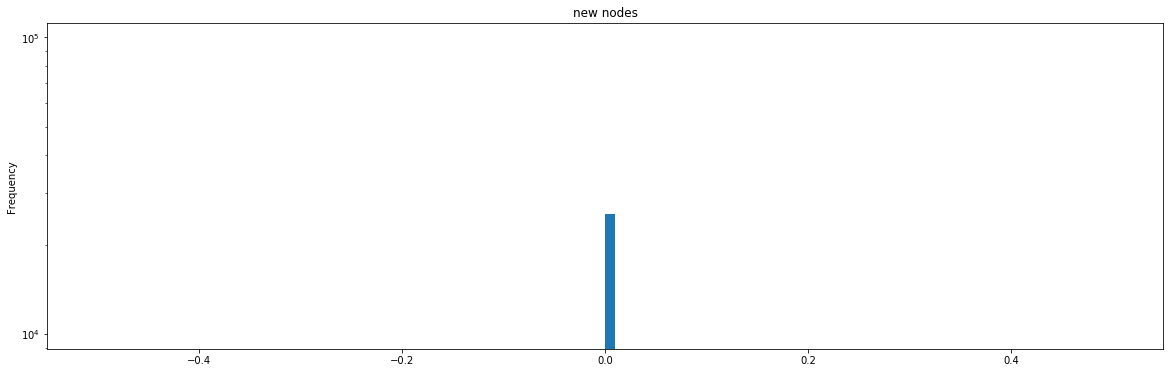

In [11]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['n_coupled_spins'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

In [12]:
dfs['new'].sort_values(by = 'coupling', ascending = False)

,active_partitions,cache_age_misses,cache_hits,cache_misses,coupled_values,coupling,edges,edges_getmem,edges_updates,metadata,...,summary_actor_partitions,summary_time_window,summary_update_neighbors,summary_update_neighbors_body,summary_update_neighbors_getmem,summary_update_neighbors_lock,summary_update_neighbors_unlock,throttling,timestep,total
15122,47,4722,16651,399,0.021,0.018,25.763,23.025,2.213,0.519,...,0.031,0.035,11.534,0.527,3.353,4.000,3.645,0.053,53,38.039
24778,49,8927,28942,392,0.016,0.016,26.757,24.304,2.173,0.254,...,0.022,0.017,5.181,0.529,1.577,1.588,1.479,0.030,96,32.351
21714,46,6789,34258,416,0.028,0.016,12.821,10.185,2.287,0.417,...,0.034,0.020,10.363,0.526,3.256,3.418,3.149,0.066,96,23.837
17485,49,4730,26701,426,0.017,0.016,9.902,7.401,2.180,0.384,...,0.026,0.031,11.529,0.525,3.313,3.916,3.763,0.045,74,22.014
22730,46,7958,33413,412,0.016,0.015,10.740,8.153,2.188,0.446,...,0.034,0.019,9.088,0.579,2.581,3.141,2.778,0.053,98,20.472
19254,46,5154,28214,402,0.023,0.015,10.758,8.406,2.050,0.326,...,0.028,0.019,9.982,0.519,3.067,3.361,3.023,0.077,83,21.290
1897,47,424,2636,424,0.015,0.015,10.171,7.703,2.188,0.300,...,0.026,0.033,11.734,0.511,2.560,3.966,4.690,0.032,8,22.392
5795,46,1270,7870,409,0.015,0.014,9.748,7.226,2.210,0.144,...,0.019,0.028,6.643,0.528,2.082,2.109,1.914,0.035,23,16.711
24154,47,11292,23966,398,0.017,0.014,19.151,16.521,2.241,0.331,...,0.021,0.024,7.551,0.519,2.338,2.367,2.319,0.028,87,27.202
11071,48,3013,15850,414,0.024,0.013,11.657,9.149,2.195,0.276,...,0.039,0.023,9.549,0.528,2.740,3.087,3.180,0.087,46,21.764


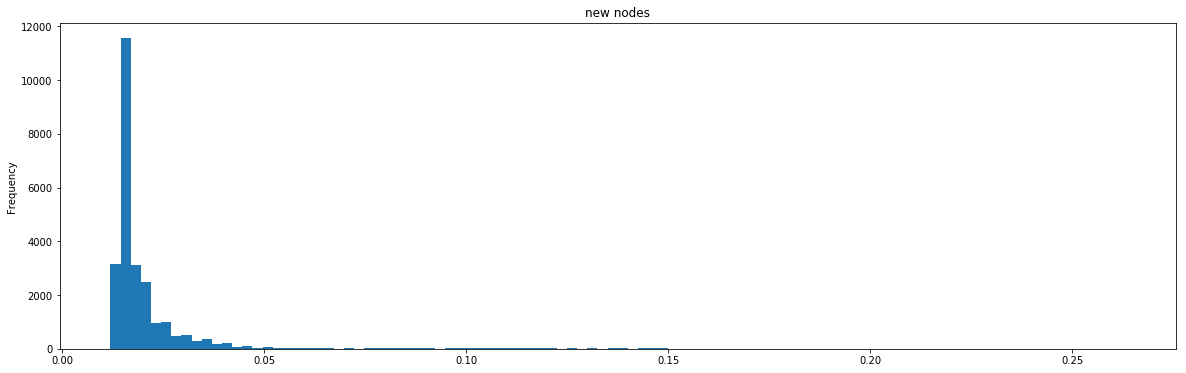

In [13]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['coupled_values'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes')

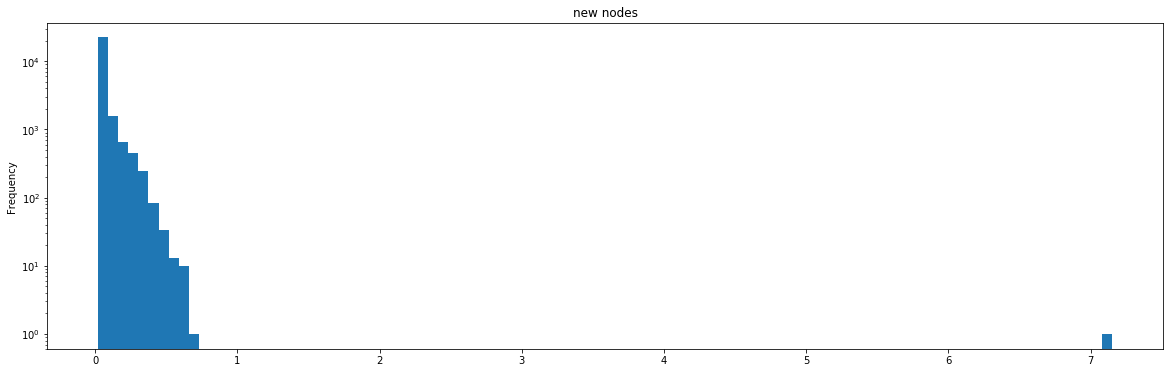

In [14]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['throttling'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

In [15]:
# Who does the most throttling and least throttling?
dfs['new'].sort_values(by = 'throttling')[['throttling', 'pe', 'timestep']].head(10)

,throttling,pe,timestep
629,0.018,255,6
14876,0.019,255,66
25343,0.020,109,100
25301,0.020,109,90
25300,0.020,105,98
237,0.020,255,3
238,0.020,255,4
1967,0.020,255,11
628,0.020,255,5
21067,0.020,255,94


In [16]:
# Who does the most throttling and least throttling?
dfs['new'].sort_values(by = 'throttling', ascending = False)[['throttling', 'pe', 'timestep']].head(10)

,throttling,pe,timestep
21158,7.152,213,91
23946,0.697,100,58
23443,0.633,97,59
24043,0.628,97,63
23815,0.614,100,57
23817,0.613,106,55
23822,0.612,96,59
24363,0.599,97,67
23811,0.597,97,61
1499,0.597,96,7


In [26]:
# Who are the slowest PEs?
df = dfs['new']
u = df[df['total'] > 55.0]['pe'].unique()
u.sort()
u

array([ 96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 110, 111])

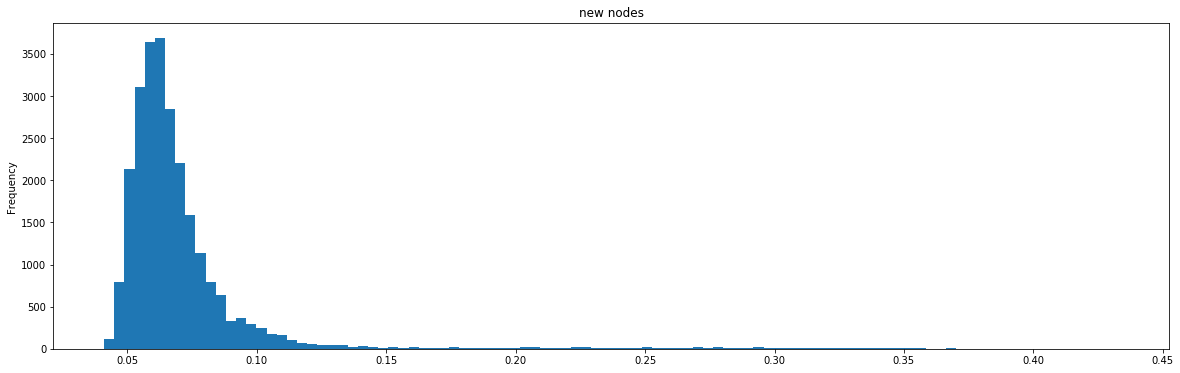

In [17]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['neighbor_updates'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes')

In [ ]:
dfs['new']['coupling'].min()

In [ ]:
# 47, 48 do more throttling than 0, 255. However, they appear to only do this throttling
# very, very early in the simulation (around timestep 10) but when they do it, it is
# significant (>2 seconds).
interesting_pes = [0, 255, 47, 48]

df = dfs['new']
interesting_dfs = {}
for pe in interesting_pes:
    interesting_dfs[pe] = df[df['pe'].isin([pe])].sort_values(by = 'timestep')

In [ ]:
interesting_dfs[interesting_pes[0]].columns

In [ ]:
def plot_for_metric(metric):
    len_shortest_df = 90
    
    d = {'timestep': interesting_dfs[interesting_pes[0]]['timestep'].values[:len_shortest_df]}
    for pe in interesting_pes:
        d[str(pe)] = interesting_dfs[pe][metric].values[:len_shortest_df]
    
    pd.DataFrame(d).plot(kind = 'line', x = 'timestep', figsize = (20.0, 6.0))

plot_for_metric('total')

In [ ]:
plot_for_metric('metadata')

In [ ]:
# 'coupled_values', 'coupling', 'edges', 'neighbor_updates', 'summary', 'throttling'
plot_for_metric('coupled_values')

In [ ]:
plot_for_metric('coupling')

In [ ]:
plot_for_metric('n_coupled_spins')

In [ ]:
plot_for_metric('edges')

In [ ]:
plot_for_metric('edges_updates')

In [ ]:
plot_for_metric('edges_getmem')

In [ ]:
plot_for_metric('neighbor_updates')

In [ ]:
plot_for_metric('summary')

In [ ]:
plot_for_metric('summary_actor_partitions')

In [ ]:
plot_for_metric('summary_time_window')

In [ ]:
plot_for_metric('summary_update_neighbors')

In [ ]:
plot_for_metric('summary_update_neighbors_lock')

In [ ]:
plot_for_metric('summary_update_neighbors_getmem')

In [ ]:
plot_for_metric('summary_update_neighbors_unlock')

In [ ]:
plot_for_metric('n_neighbors')

In [ ]:
def compute_mean(metric):
    d = {}
    for pe in interesting_pes:
        d[pe] = interesting_dfs[pe][metric].mean()
    return d

compute_mean('n_neighbors')

In [ ]:
plot_for_metric('summary_update_neighbors_body')

In [ ]:
plot_for_metric('throttling')

In [ ]:
#[u'active_partitions', u'cache_age_misses', u'cache_hits',
#       u'cache_misses', u'coupled_values', u'coupling', u'edges',
#       u'edges_getmem', u'edges_updates', u'metadata', u'n_coupled_spins',
#       u'n_neighbors', u'neighbor_updates', u'pe', u'spins', u'summary',
#       u'summary_actor_partitions', u'summary_time_window',
#      u'summary_update_neighbors', u'summary_update_neighbors_body',
#       u'summary_update_neighbors_getmem', u'summary_update_neighbors_lock',
#       u'summary_update_neighbors_unlock', u'throttling', u'timestep',
#       u'total']
plot_for_metric('throttling')